In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pylab as plt
import plotly.express as px

from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

from sklearn.preprocessing import StandardScaler

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score

In [2]:
# Load the dataset
bakery_sales = pd.read_csv('bakery_sales_2021-2022.csv')

# Display the first few rows of each dataframe to understand their structure
bakery_sales.head()

,Unnamed: 0,date,time,ticket_number,Article,Quantity,UNIT_PRICE
0,0,2021-01-02,08:38,150040.0,BAGUETTE,1.0,"0,90 €"
1,1,2021-01-02,08:38,150040.0,PAIN AU CHOCOLAT,3.0,"1,20 €"
2,4,2021-01-02,09:14,150041.0,PAIN AU CHOCOLAT,2.0,"1,20 €"
3,5,2021-01-02,09:14,150041.0,PAIN,1.0,"1,15 €"
4,8,2021-01-02,09:25,150042.0,TRADITIONAL BAGUETTE,5.0,"1,20 €"


### Bakery Sales Data

In [3]:
bakery_sales = bakery_sales.drop(columns=['Unnamed: 0'])

# Convert UNIT_PRICE to numeric after removing the '€' sign and converting comma to dot for proper numeric conversion
bakery_sales['UNIT_PRICE'] = bakery_sales['UNIT_PRICE'].str.replace('€', '').str.replace(',', '.').astype(float)

# Initial inspection of bakery sales data
bakery_sales_info = {
    "shape": bakery_sales.shape,
    "columns": bakery_sales.columns,
    "missing_values": bakery_sales.isnull().sum(),
    "duplicates_values": bakery_sales.duplicated().sum()
}


bakery_sales_info, bakery_sales.describe()

({'shape': (234005, 6),
  'columns': Index(['date', 'time', 'ticket_number', 'Article', 'Quantity', 'UNIT_PRICE'], dtype='object'),
  'missing_values': date             0
  time             0
  ticket_number    0
  Article          0
  Quantity         0
  UNIT_PRICE       0
  dtype: int64,
  'duplicates_values': 1210},
        ticket_number       Quantity     UNIT_PRICE
 count  234005.000000  234005.000000  234005.000000
 mean   219201.258738       1.538377       1.662195
 std     40053.223896       1.289603       1.722720
 min    150040.000000    -200.000000       0.000000
 25%    184754.000000       1.000000       1.100000
 50%    218807.000000       1.000000       1.200000
 75%    253927.000000       2.000000       1.500000
 max    288913.000000     200.000000      60.000000)

Dataset Summary

- **Shape of the dataset:** (234005, 6)
- **Columns:**
  - 'date'
  - 'time'
  - 'ticket_number'
  - 'Article'
  - 'Quantity'
  - 'UNIT_PRICE'
- **Missing values:** None
- **Duplicate rows:** 1210

In [4]:
# Ensure the 'Article' and 'date' columns are in the correct format
bakery_sales['Article'] = bakery_sales['Article'].str.title()
bakery_sales['date'] = pd.to_datetime(bakery_sales['date'])

# Display unique values in 'Article' column
unique_articles = bakery_sales['Article'].unique()
print(f"Unique values in 'Article' column:\n{unique_articles}")

# Count the occurrences of each unique value in 'Article' column
article_counts = bakery_sales['Article'].value_counts()
print(f"Counts of each unique value in 'Article' column:\n{article_counts}")

# Check for rows with suspicious or unexpected values in 'Article' column
suspicious_articles = bakery_sales[bakery_sales['Article'].str.contains(r'[^a-zA-Z0-9\s]', na=False)]
print(f"Rows with suspicious values in 'Article' column:\n{suspicious_articles}")

# Summary statistics for 'Quantity' column
quantity_stats = bakery_sales['Quantity'].describe()
print(f"Summary statistics for 'Quantity' column:\n{quantity_stats}")


Unique values in 'Article' column:
['Baguette' 'Pain Au Chocolat' 'Pain' 'Traditional Baguette' 'Croissant'
 'Banette' 'Banettine' 'Special Bread' 'Coupe' 'Sand Jb Emmental'
 'Kouign Amann' 'Boule 200G' 'Boule 400G' 'Gal Frangipane 6P' 'Campagne'
 'Moisson' 'Cafe Ou Eau' 'Brioche' 'Cereal Baguette' 'Seigle' 'Complet'
 'Divers Patisserie' 'Gal Frangipane 4P' 'Cookie' 'Ficelle'
 'Pain Aux Raisins' 'Gal Pomme 6P' 'Gal Pomme 4P' 'Financier X5'
 'Vik Bread' 'Divers Viennoiserie' 'Gache' 'Sandwich Complet'
 'Pain Banette' 'Grand Far Breton' 'Quim Bread' 'Special Bread Kg'
 'Gd Kouign Amann' 'Boule Polka' 'Demi Baguette' 'Chausson Aux Pommes'
 'Baguette Graine' 'Divers Confiserie' 'Sucette' 'Divers Boulangerie'
 'Boisson 33Cl' 'Pates' 'Formule Sandwich' 'Divers Sandwichs'
 'Croissant Amandes' 'Pain Choco Amandes' 'Sachet Viennoiserie' 'Nantais'
 'Chocolat' 'Pain S/Sel' 'Fondant Chocolat' 'Gal Poire Choco 6P'
 'Gal Poire Choco 4P' 'Galette 8 Pers' 'Sand Jb' 'Sachet De Crouton'
 'Grande Sucette

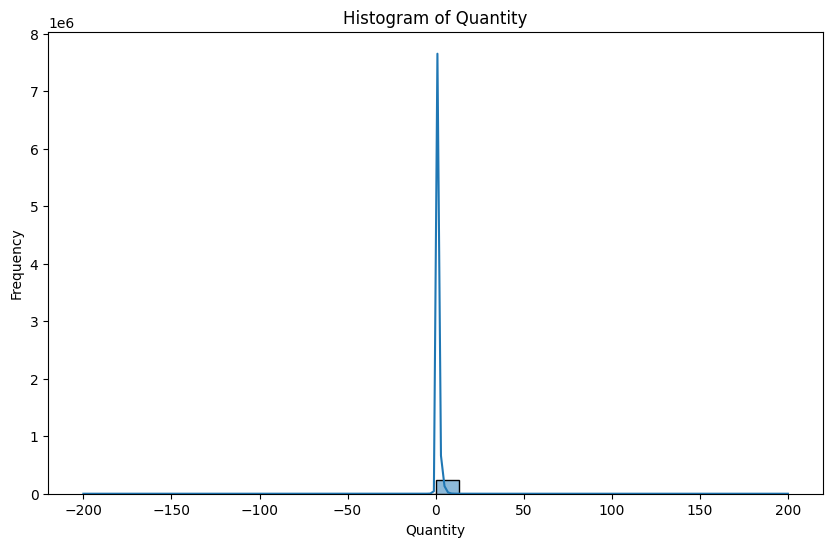

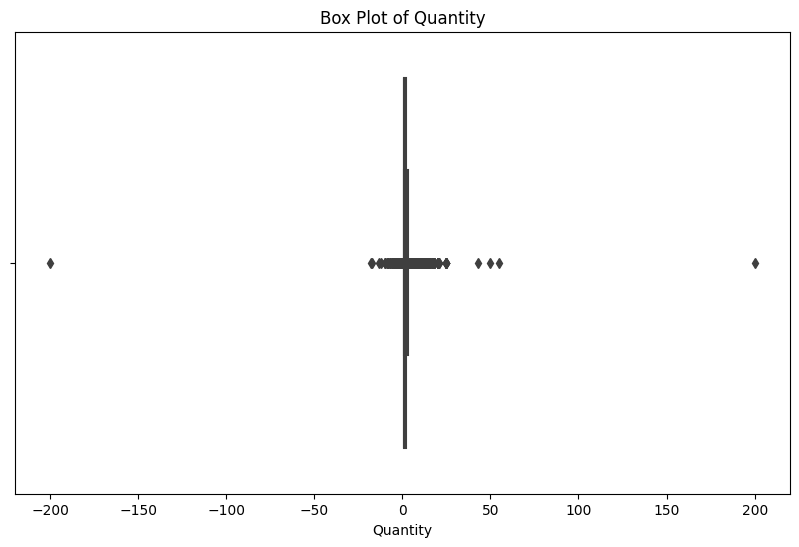

In [5]:
# Histogram for 'Quantity' column
plt.figure(figsize=(10, 6))
sns.histplot(bakery_sales['Quantity'], bins=30, kde=True)
plt.title('Histogram of Quantity')
plt.xlabel('Quantity')
plt.ylabel('Frequency')
plt.show()

# Box plot for 'Quantity' column
plt.figure(figsize=(10, 6))
sns.boxplot(x=bakery_sales['Quantity'])
plt.title('Box Plot of Quantity')
plt.xlabel('Quantity')
plt.show()


In [6]:
# Calculate the mode of unit prices for each article
mode_prices = bakery_sales[bakery_sales['UNIT_PRICE'] != 0].groupby('Article')['UNIT_PRICE'].agg(lambda x: x.mode().iloc[0]).reset_index()
mode_prices.columns = ['Article', 'ModeUnitPrice']

# Merge the mode prices back to the original dataframe
bakery_sales = bakery_sales.merge(mode_prices, on='Article', how='left')

# Replace zero unit prices with the mode unit price for each article
bakery_sales['UNIT_PRICE'] = bakery_sales.apply(
    lambda row: row['ModeUnitPrice'] if row['UNIT_PRICE'] == 0 else row['UNIT_PRICE'], axis=1
)

# Data cleaning
def clean_bakery_sales_data(df):
    # Remove 'Unnamed: 0' column if it exists
    if 'Unnamed: 0' in df.columns:
        df = df.drop(columns=['Unnamed: 0'])

    # Drop duplicate rows
    df = df.drop_duplicates()

    # Remove rows where Article is '.'
    df = df[df['Article'] != '.']

    # Remove rows where UNIT PRICE is blank
    df = df[df['UNIT_PRICE'].notna()]

    # Remove rows with Quantity greater than 100
    df = df[df['Quantity'] <= 100]

    # Remove rows with negative Quantity values
    df = df[df['Quantity'] >= 0]

    # Convert 'Article' values to title case
    df['Article'] = df['Article'].str.title()

    # Convert Quantity and Unit Price to numeric
    df['Quantity'] = pd.to_numeric(df['Quantity'], errors='coerce')
    df['UNIT_PRICE'] = pd.to_numeric(df['UNIT_PRICE'], errors='coerce')

    # Rename columns to more intuitive names
    df = df.rename(columns={
        'date': 'Date',
        'time': 'Time',
        'ticket_number': 'TicketNumber',
        'Article': 'Product',  
        'Quantity': 'QuantitySold',  # Changed from 'Quantity' to 'QuantitySold'
        'UNIT_PRICE': 'UnitPrice',
        'revenue': 'Revenue'
    })

    # Create the Revenue column
    df['Revenue'] = df['UnitPrice'] * df['QuantitySold']

    # Drop the ModeUnitPrice column as it's no longer needed
    df = df.drop(columns=['ModeUnitPrice'])

    return df

# Clean the bakery sales data
bakery_sales_cleaned = clean_bakery_sales_data(bakery_sales)

# Check for rows where 'Product' is '.'
num_rows_dot_product = bakery_sales_cleaned[bakery_sales_cleaned['Product'] == '.'].shape[0]
print(f"Number of rows where 'Product' is '.': {num_rows_dot_product}")
print("Rows where 'Product' is '.':")
print(bakery_sales_cleaned[bakery_sales_cleaned['Product'] == '.'])

# Display the cleaned data
print(bakery_sales_cleaned.info())
print(bakery_sales_cleaned.head())


Number of rows where 'Product' is '.': 0
Rows where 'Product' is '.':
Empty DataFrame
Columns: [Date, Time, TicketNumber, Product, QuantitySold, UnitPrice, Revenue]
Index: []
<class 'pandas.core.frame.DataFrame'>
Index: 231500 entries, 0 to 234004
Data columns (total 7 columns):
 #   Column        Non-Null Count   Dtype         
---  ------        --------------   -----         
 0   Date          231500 non-null  datetime64[ns]
 1   Time          231500 non-null  object        
 2   TicketNumber  231500 non-null  float64       
 3   Product       231500 non-null  object        
 4   QuantitySold  231500 non-null  float64       
 5   UnitPrice     231500 non-null  float64       
 6   Revenue       231500 non-null  float64       
dtypes: datetime64[ns](1), float64(4), object(2)
memory usage: 14.1+ MB
None
        Date   Time  TicketNumber               Product  QuantitySold  \
0 2021-01-02  08:38      150040.0              Baguette           1.0   
1 2021-01-02  08:38      150040.0     

In [7]:
bakery_sales_cleaned.shape

(231500, 7)

In [8]:
bakery_data = bakery_sales_cleaned

In [9]:
# Aggregate the data by date and product, summing up the 'QuantitySold' and 'Revenue'
daily_product = bakery_data.groupby(['Date', 'Product']).agg({
    'QuantitySold': 'sum',
    'Revenue': 'sum'
}).reset_index()

# Create the additional date-related columns
daily_product['Day'] = daily_product['Date'].dt.day
daily_product['Month'] = daily_product['Date'].dt.month
daily_product['Year'] = daily_product['Date'].dt.year
daily_product['Weekday'] = daily_product['Date'].dt.day_name()
daily_product['Weekend'] = daily_product['Weekday'].isin(['Saturday', 'Sunday'])


In [10]:
daily_product

,Date,Product,QuantitySold,Revenue,Day,Month,Year,Weekday,Weekend
0,2021-01-02,Baguette,46.0,41.4,2,1,2021,Saturday,True
1,2021-01-02,Banette,40.0,42.0,2,1,2021,Saturday,True
2,2021-01-02,Banettine,6.0,3.6,2,1,2021,Saturday,True
3,2021-01-02,Boule 200G,6.0,6.6,2,1,2021,Saturday,True
4,2021-01-02,Boule 400G,11.0,16.5,2,1,2021,Saturday,True
...,...,...,...,...,...,...,...,...,...
29191,2022-09-30,Special Bread Kg,1.0,5.2,30,9,2022,Friday,False
29192,2022-09-30,Sucette,1.0,0.3,30,9,2022,Friday,False
29193,2022-09-30,Tartelette,3.0,6.6,30,9,2022,Friday,False
29194,2022-09-30,Traditional Baguette,141.0,183.3,30,9,2022,Friday,False


In [11]:
daily_product.to_csv('final_bakery.csv', index=False)

### Weather Data

In [12]:
weather_data = pd.read_csv('weather_2021.01.01-2022.10.31.csv')

In [13]:
weather_data.shape

(669, 11)

In [14]:
# Check for missing values
missing_values = weather_data.isnull().sum()
print(f"Missing values in each column:\n{missing_values}")


Missing values in each column:
date      0
tavg      0
tmin      0
tmax      0
prcp      0
snow    654
wdir      2
wspd      2
wpgt     14
pres      2
tsun    669
dtype: int64


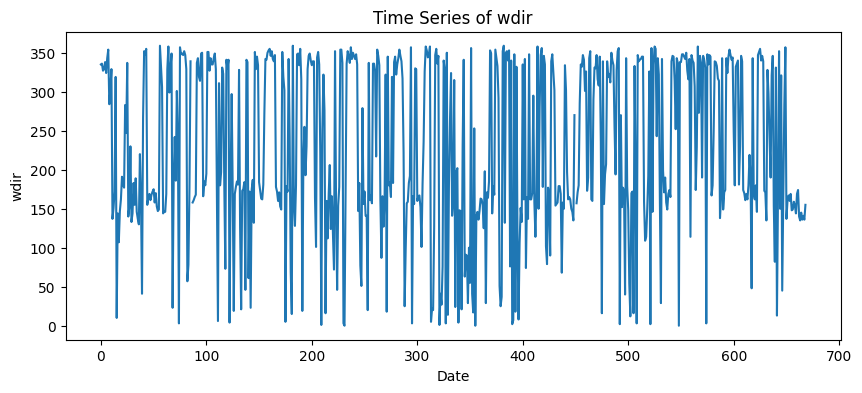

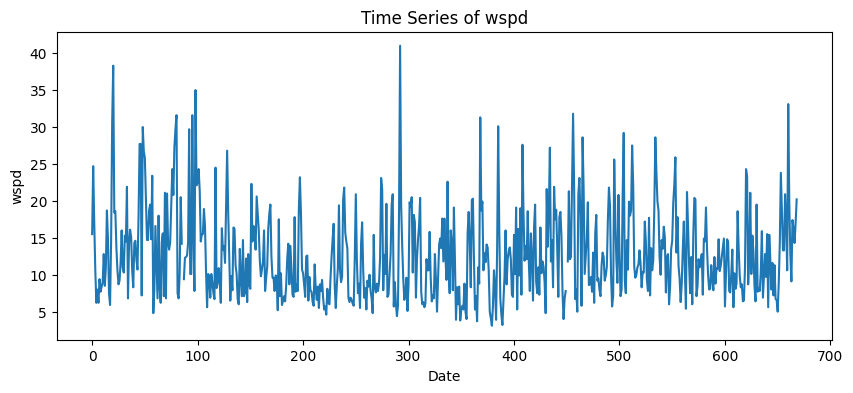

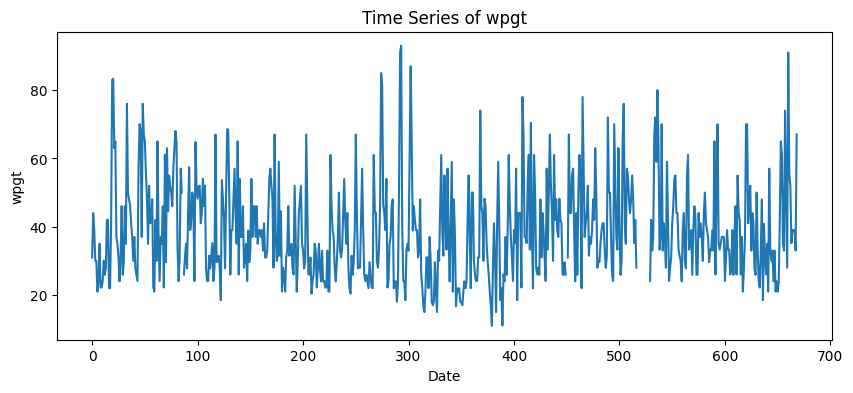

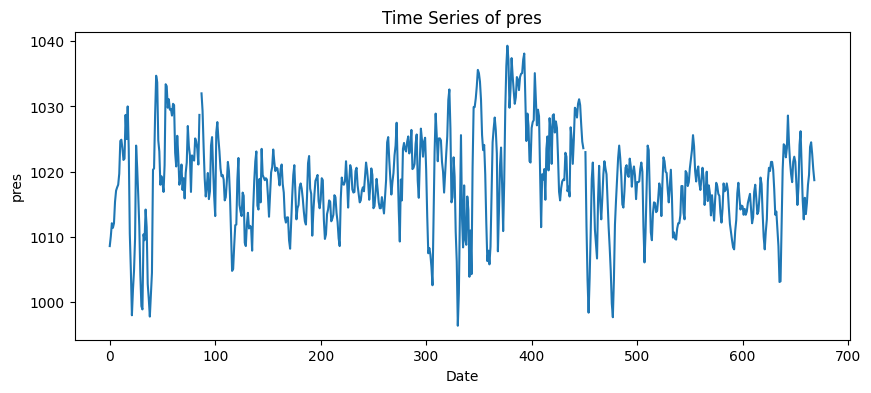

In [15]:
# Plot each weather variable to understand its temporal pattern
weather_columns = ['wdir', 'wspd', 'wpgt', 'pres']

for column in weather_columns:
    plt.figure(figsize=(10, 4))
    plt.plot(weather_data[column])
    plt.title(f'Time Series of {column}')
    plt.xlabel('Date')
    plt.ylabel(column)
    plt.show()


In [16]:
# Convert 'date' column to datetime
weather_data['date'] = pd.to_datetime(weather_data['date'])

# Generate a complete date range from 2021-01-01 to 2022-10-31
complete_date_range = pd.date_range(start='2021-01-01', end='2022-10-31')

# Check for missing dates
missing_dates = complete_date_range.difference(weather_data['date'].unique())

print(f"Number of missing dates: {len(missing_dates)}")
print(f"Missing dates:\n{missing_dates}")

Number of missing dates: 0
Missing dates:
DatetimeIndex([], dtype='datetime64[ns]', freq='D')


In [17]:
# Remove columns with more than 50% missing values
columns_to_drop = ['snow', 'tsun']
weather_data = weather_data.drop(columns=columns_to_drop)
print(f"Columns dropped: {columns_to_drop}")


# List of columns to apply linear interpolation
linear_interp_columns = ['wdir', 'wspd', 'wpgt', 'pres']

# Apply linear interpolation
weather_data[linear_interp_columns] = weather_data[linear_interp_columns].interpolate(method='linear', limit_direction='both')

weather_data = weather_data.rename(columns={
    'date': 'Date',
    'tavg': 'AvgTemp',
    'tmin': 'MinTemp',
    'tmax': 'MaxTemp',
    'prcp': 'Precipitation',
    'wdir': 'WindDir',
    'wspd': 'WindSpeed',
    'wpgt': 'WindGust',
    'pres': 'Pressure'
})

weather_data.isnull().sum()

Columns dropped: ['snow', 'tsun']


Date             0
AvgTemp          0
MinTemp          0
MaxTemp          0
Precipitation    0
WindDir          0
WindSpeed        0
WindGust         0
Pressure         0
dtype: int64

In [18]:
# Verify the cleaned data
weather_data.head()

,Date,AvgTemp,MinTemp,MaxTemp,Precipitation,WindDir,WindSpeed,WindGust,Pressure
0,2021-01-01,2.7,1.5,5.7,15.2,335.0,15.5,31.0,1008.6
1,2021-01-02,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1
2,2021-01-03,0.7,-0.3,1.6,0.0,327.0,17.1,38.9,1012.1
3,2021-01-04,0.0,-1.0,1.1,0.0,329.0,10.6,30.0,1011.4
4,2021-01-05,0.8,-0.9,2.1,0.0,338.0,6.2,30.0,1012.1


In [19]:
weather_data.to_csv('final_weather.csv', index= False)

### Merged Dataset

In [20]:
# Load the provided datasets
bakery_data_path = 'final_bakery.csv'
weather_data_path = 'final_weather.csv'

bakery_data = pd.read_csv(bakery_data_path)
weather_data = pd.read_csv(weather_data_path)

# Display the first few rows of each dataset to understand their structure
bakery_data.head(), weather_data.head()

(         Date     Product  QuantitySold  Revenue  Day  Month  Year   Weekday  \
 0  2021-01-02    Baguette          46.0     41.4    2      1  2021  Saturday   
 1  2021-01-02     Banette          40.0     42.0    2      1  2021  Saturday   
 2  2021-01-02   Banettine           6.0      3.6    2      1  2021  Saturday   
 3  2021-01-02  Boule 200G           6.0      6.6    2      1  2021  Saturday   
 4  2021-01-02  Boule 400G          11.0     16.5    2      1  2021  Saturday   
 
    Weekend  
 0     True  
 1     True  
 2     True  
 3     True  
 4     True  ,
          Date  AvgTemp  MinTemp  MaxTemp  Precipitation  WindDir  WindSpeed  \
 0  2021-01-01      2.7      1.5      5.7           15.2    335.0       15.5   
 1  2021-01-02      1.3      0.5      2.7            0.8    336.0       24.7   
 2  2021-01-03      0.7     -0.3      1.6            0.0    327.0       17.1   
 3  2021-01-04      0.0     -1.0      1.1            0.0    329.0       10.6   
 4  2021-01-05      0.8    

In [21]:
# Convert the 'Date' column to datetime format
bakery_data['Date'] = pd.to_datetime(bakery_data['Date'])
weather_data['Date'] = pd.to_datetime(weather_data['Date'])

# Merge the datasets on the 'Date' column
merged_data = pd.merge(bakery_data, weather_data, on='Date', how='left')
merged_data

,Date,Product,QuantitySold,Revenue,Day,Month,Year,Weekday,Weekend,AvgTemp,MinTemp,MaxTemp,Precipitation,WindDir,WindSpeed,WindGust,Pressure
0,2021-01-02,Baguette,46.0,41.4,2,1,2021,Saturday,True,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1
1,2021-01-02,Banette,40.0,42.0,2,1,2021,Saturday,True,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1
2,2021-01-02,Banettine,6.0,3.6,2,1,2021,Saturday,True,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1
3,2021-01-02,Boule 200G,6.0,6.6,2,1,2021,Saturday,True,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1
4,2021-01-02,Boule 400G,11.0,16.5,2,1,2021,Saturday,True,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29191,2022-09-30,Special Bread Kg,1.0,5.2,30,9,2022,Friday,False,10.2,7.0,14.6,0.0,346.0,9.9,40.8,1011.7
29192,2022-09-30,Sucette,1.0,0.3,30,9,2022,Friday,False,10.2,7.0,14.6,0.0,346.0,9.9,40.8,1011.7
29193,2022-09-30,Tartelette,3.0,6.6,30,9,2022,Friday,False,10.2,7.0,14.6,0.0,346.0,9.9,40.8,1011.7
29194,2022-09-30,Traditional Baguette,141.0,183.3,30,9,2022,Friday,False,10.2,7.0,14.6,0.0,346.0,9.9,40.8,1011.7


In [22]:
merged_data

,Date,Product,QuantitySold,Revenue,Day,Month,Year,Weekday,Weekend,AvgTemp,MinTemp,MaxTemp,Precipitation,WindDir,WindSpeed,WindGust,Pressure
0,2021-01-02,Baguette,46.0,41.4,2,1,2021,Saturday,True,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1
1,2021-01-02,Banette,40.0,42.0,2,1,2021,Saturday,True,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1
2,2021-01-02,Banettine,6.0,3.6,2,1,2021,Saturday,True,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1
3,2021-01-02,Boule 200G,6.0,6.6,2,1,2021,Saturday,True,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1
4,2021-01-02,Boule 400G,11.0,16.5,2,1,2021,Saturday,True,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29191,2022-09-30,Special Bread Kg,1.0,5.2,30,9,2022,Friday,False,10.2,7.0,14.6,0.0,346.0,9.9,40.8,1011.7
29192,2022-09-30,Sucette,1.0,0.3,30,9,2022,Friday,False,10.2,7.0,14.6,0.0,346.0,9.9,40.8,1011.7
29193,2022-09-30,Tartelette,3.0,6.6,30,9,2022,Friday,False,10.2,7.0,14.6,0.0,346.0,9.9,40.8,1011.7
29194,2022-09-30,Traditional Baguette,141.0,183.3,30,9,2022,Friday,False,10.2,7.0,14.6,0.0,346.0,9.9,40.8,1011.7


### EDA

In [23]:
data = merged_data
data

,Date,Product,QuantitySold,Revenue,Day,Month,Year,Weekday,Weekend,AvgTemp,MinTemp,MaxTemp,Precipitation,WindDir,WindSpeed,WindGust,Pressure
0,2021-01-02,Baguette,46.0,41.4,2,1,2021,Saturday,True,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1
1,2021-01-02,Banette,40.0,42.0,2,1,2021,Saturday,True,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1
2,2021-01-02,Banettine,6.0,3.6,2,1,2021,Saturday,True,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1
3,2021-01-02,Boule 200G,6.0,6.6,2,1,2021,Saturday,True,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1
4,2021-01-02,Boule 400G,11.0,16.5,2,1,2021,Saturday,True,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
29191,2022-09-30,Special Bread Kg,1.0,5.2,30,9,2022,Friday,False,10.2,7.0,14.6,0.0,346.0,9.9,40.8,1011.7
29192,2022-09-30,Sucette,1.0,0.3,30,9,2022,Friday,False,10.2,7.0,14.6,0.0,346.0,9.9,40.8,1011.7
29193,2022-09-30,Tartelette,3.0,6.6,30,9,2022,Friday,False,10.2,7.0,14.6,0.0,346.0,9.9,40.8,1011.7
29194,2022-09-30,Traditional Baguette,141.0,183.3,30,9,2022,Friday,False,10.2,7.0,14.6,0.0,346.0,9.9,40.8,1011.7


##### Distribution of Sales and Revenue by Product

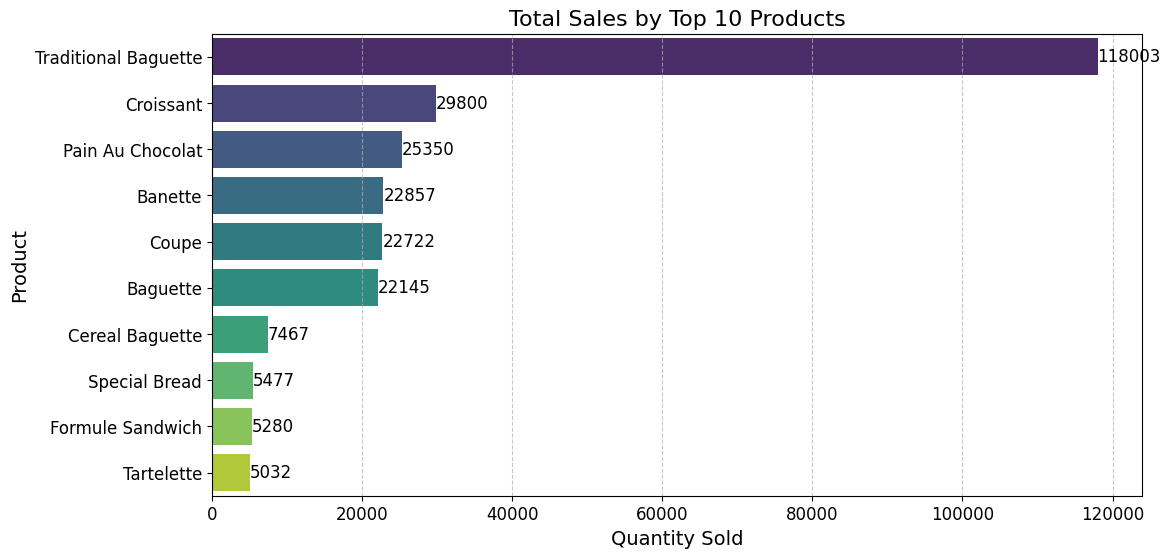

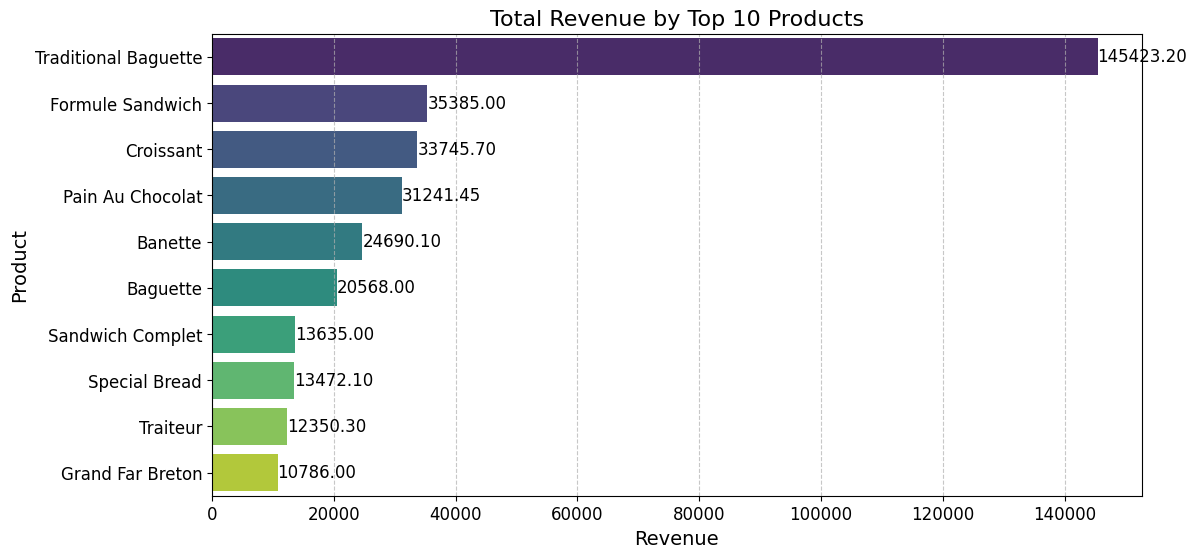

In [24]:
# Aggregate data by product
product_sales = bakery_data.groupby('Product')['QuantitySold'].sum().sort_values(ascending=False)
product_revenue = bakery_data.groupby('Product')['Revenue'].sum().sort_values(ascending=False)

# Get top 10 products by sales and revenue

top10_sales = product_sales.head(10)
top10_revenue = product_revenue.head(10)

# Improved Total Sales by Top 10 Products plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top10_sales.values, y=top10_sales.index, palette="viridis")
plt.title('Total Sales by Top 10 Products', fontsize=16)
plt.xlabel('Quantity Sold', fontsize=14)
plt.ylabel('Product', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for index, value in enumerate(top10_sales.values):
    plt.text(value, index, f'{value:.0f}', va='center', ha='left', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

# Improved Total Revenue by Top 10 Products plot
plt.figure(figsize=(12, 6))
sns.barplot(x=top10_revenue.values, y=top10_revenue.index, palette="viridis")
plt.title('Total Revenue by Top 10 Products', fontsize=16)
plt.xlabel('Revenue', fontsize=14)
plt.ylabel('Product', fontsize=14)
plt.xticks(fontsize=12)
plt.yticks(fontsize=12)
for index, value in enumerate(top10_revenue.values):
    plt.text(value, index, f'{value:.2f}', va='center', ha='left', fontsize=12)
plt.grid(axis='x', linestyle='--', alpha=0.7)
plt.show()

#### Top Selling Product EDA

In [25]:
# Identify the top-selling product by summing the quantity sold
top_product = data.groupby('Product')['QuantitySold'].sum().idxmax()
top_product_data = data[data['Product'] == top_product]

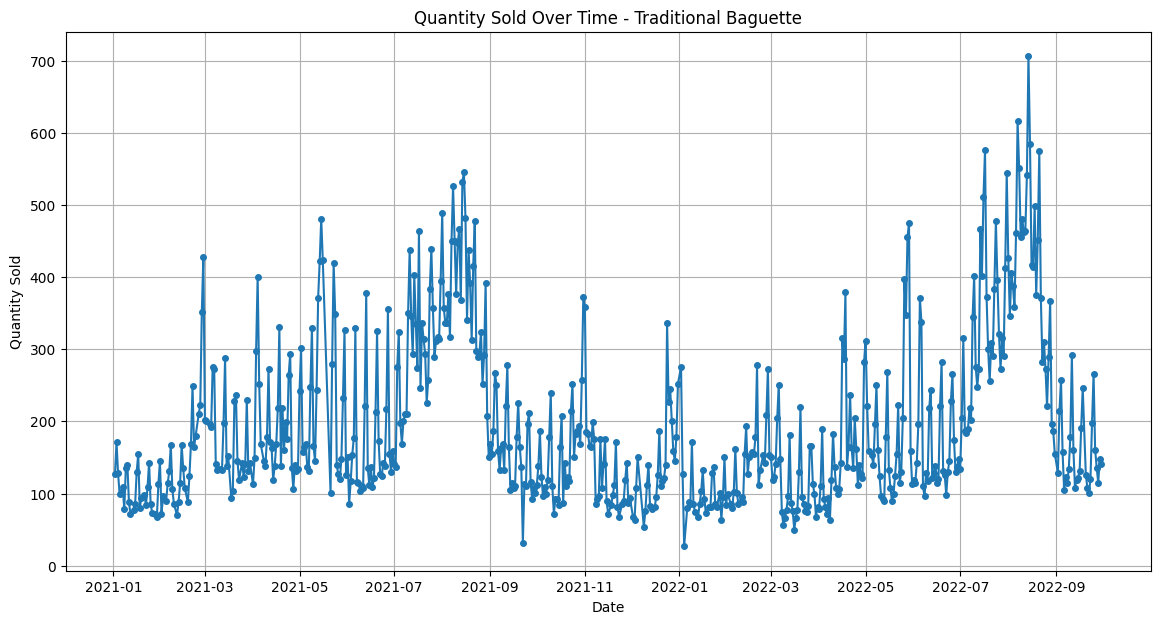

In [26]:
# Plotting the quantity sold over time for Traditional Baguette
plt.figure(figsize=(14, 7))
plt.plot(top_product_data['Date'], top_product_data['QuantitySold'], marker='o', linestyle='-', markersize=4)
plt.title('Quantity Sold Over Time - Traditional Baguette')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.grid(True)
plt.show()


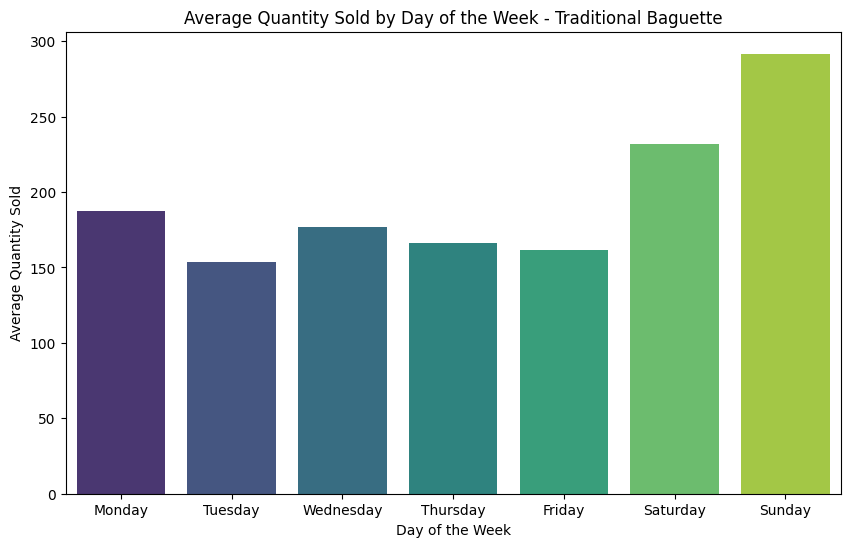

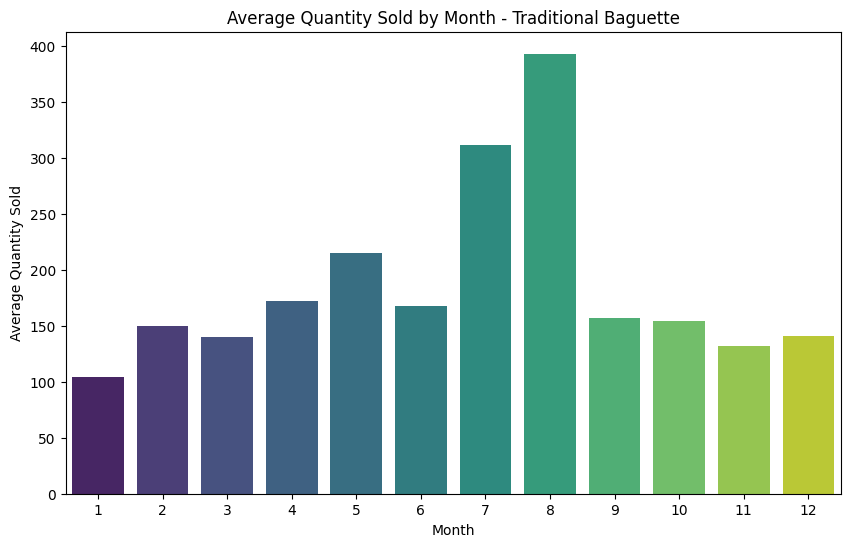

C:\Users\omi__\AppData\Local\Temp\ipykernel_30328\1827796889.py:37: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_product_data['Season'] = top_product_data['Month'].apply(get_season)


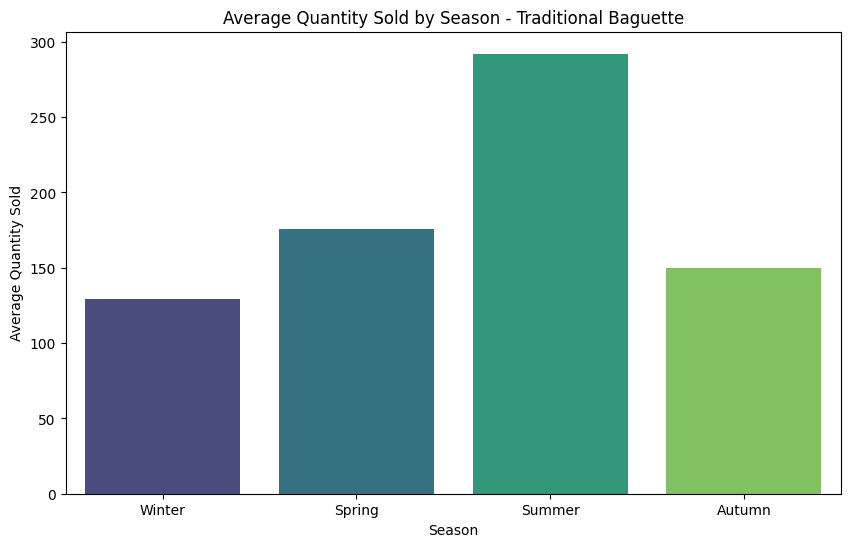

In [27]:
# Average quantity sold by day of the week
avg_sales_by_weekday = top_product_data.groupby('Weekday')['QuantitySold'].mean().reindex(
    ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
)

# Plotting the average quantity sold by day of the week
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_sales_by_weekday.index, y=avg_sales_by_weekday.values, palette='viridis')
plt.title('Average Quantity Sold by Day of the Week - Traditional Baguette')
plt.xlabel('Day of the Week')
plt.ylabel('Average Quantity Sold')
plt.show()

# Average quantity sold by month
avg_sales_by_month = top_product_data.groupby('Month')['QuantitySold'].mean()

# Plotting the average quantity sold by month
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_sales_by_month.index, y=avg_sales_by_month.values, palette='viridis')
plt.title('Average Quantity Sold by Month - Traditional Baguette')
plt.xlabel('Month')
plt.ylabel('Average Quantity Sold')
plt.show()

# Define seasons
def get_season(month):
    if month in [12, 1, 2]:
        return 'Winter'
    elif month in [3, 4, 5]:
        return 'Spring'
    elif month in [6, 7, 8]:
        return 'Summer'
    else:
        return 'Autumn'

# Add season column to the data
top_product_data['Season'] = top_product_data['Month'].apply(get_season)

# Average quantity sold by season
avg_sales_by_season = top_product_data.groupby('Season')['QuantitySold'].mean().reindex(
    ['Winter', 'Spring', 'Summer', 'Autumn']
)

# Plotting the average quantity sold by season
plt.figure(figsize=(10, 6))
sns.barplot(x=avg_sales_by_season.index, y=avg_sales_by_season.values, palette='viridis')
plt.title('Average Quantity Sold by Season - Traditional Baguette')
plt.xlabel('Season')
plt.ylabel('Average Quantity Sold')
plt.show()

Seasonality: There is a strong seasonal trend with higher sales in summer and lower sales in winter.

Weekly Pattern: Sales peak on weekends, especially Sundays.

Monthly Pattern: Sales are highest in August and lowest in January and February, indicating a potential increase in demand during summer and decrease during the start of the year.

General Trend: The data indicates significant variability with recurring peaks, suggesting that the traditional baguette sales are influenced by time-based factors, likely including holidays, weekends, and seasonal preferences.

##### Univariate Analysis

C:\Users\omi__\AppData\Local\Temp\ipykernel_30328\599561162.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  top_product_data['Date'] = pd.to_datetime(top_product_data['Date'])


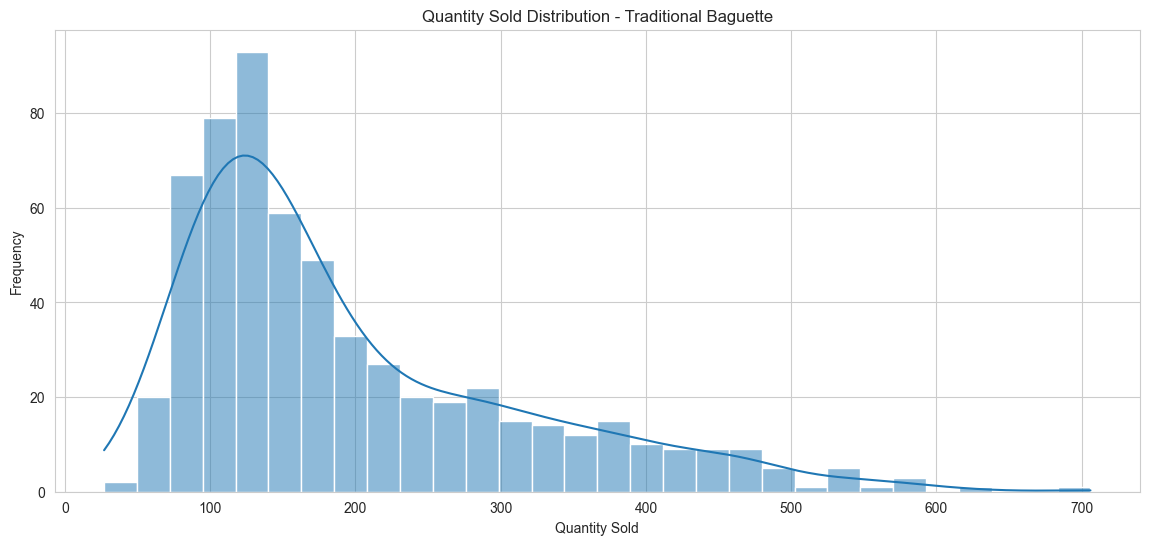

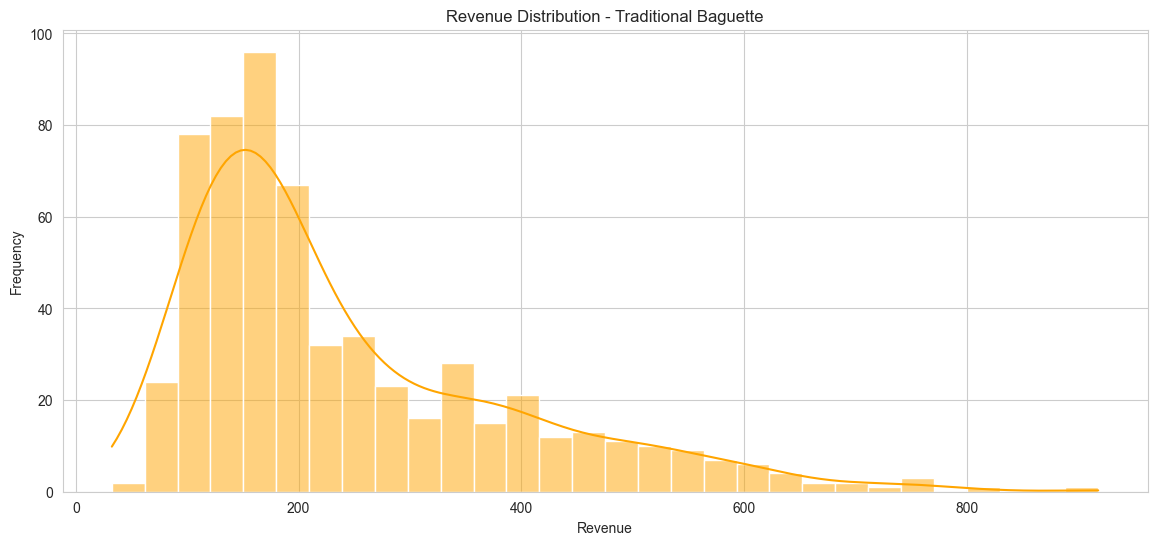

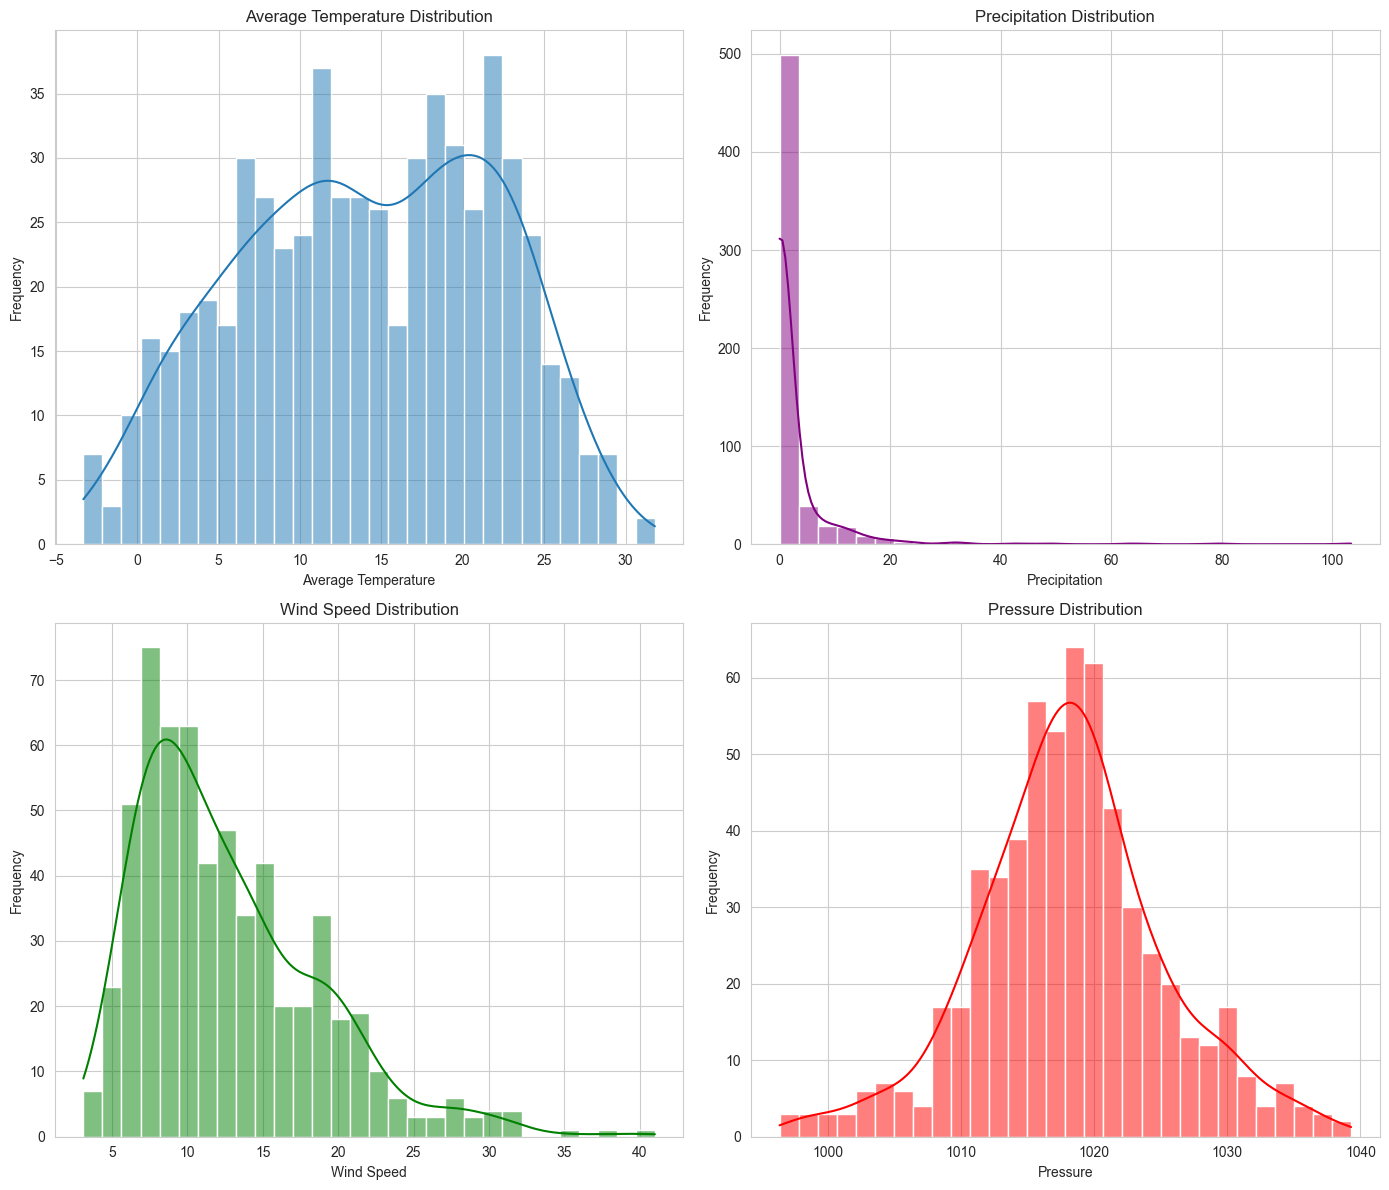

In [28]:
# Convert 'Date' to datetime format and set it as index
top_product_data['Date'] = pd.to_datetime(top_product_data['Date'])
top_product_data.set_index('Date', inplace=True)

# Set the aesthetic style of the plots
sns.set_style("whitegrid")

# Univariate Analysis - Quantity Sold Distribution
plt.figure(figsize=(14, 6))
sns.histplot(top_product_data['QuantitySold'], bins=30, kde=True)
plt.title('Quantity Sold Distribution - Traditional Baguette')
plt.xlabel('Quantity Sold')
plt.ylabel('Frequency')
plt.show()

# Univariate Analysis - Revenue Distribution
plt.figure(figsize=(14, 6))
sns.histplot(top_product_data['Revenue'], bins=30, kde=True, color='orange')
plt.title('Revenue Distribution - Traditional Baguette')
plt.xlabel('Revenue')
plt.ylabel('Frequency')
plt.show()

# Univariate Analysis - Temperature and Weather Variables
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

sns.histplot(top_product_data['AvgTemp'], bins=30, kde=True, ax=axes[0, 0])
axes[0, 0].set_title('Average Temperature Distribution')
axes[0, 0].set_xlabel('Average Temperature')
axes[0, 0].set_ylabel('Frequency')

sns.histplot(top_product_data['Precipitation'], bins=30, kde=True, ax=axes[0, 1], color='purple')
axes[0, 1].set_title('Precipitation Distribution')
axes[0, 1].set_xlabel('Precipitation')
axes[0, 1].set_ylabel('Frequency')

sns.histplot(top_product_data['WindSpeed'], bins=30, kde=True, ax=axes[1, 0], color='green')
axes[1, 0].set_title('Wind Speed Distribution')
axes[1, 0].set_xlabel('Wind Speed')
axes[1, 0].set_ylabel('Frequency')

sns.histplot(top_product_data['Pressure'], bins=30, kde=True, ax=axes[1, 1], color='red')
axes[1, 1].set_title('Pressure Distribution')
axes[1, 1].set_xlabel('Pressure')
axes[1, 1].set_ylabel('Frequency')

plt.tight_layout()
plt.show()


**Quantity Sold Distribution**

The distribution of quantity sold is right-skewed, indicating that there are more days with lower sales and fewer days with very high sales.

**Revenue Distribution**

Similar to the quantity sold distribution, the revenue distribution is also right-skewed.

**Temperature and Weather Variables**

- **Average Temperature:** Mostly centered around 0 to 15 degrees Celsius.
- **Precipitation:** Most days have low precipitation.
- **Wind Speed:** Most days have wind speeds below 20 units.
- **Pressure:** The distribution of pressure is relatively normal.


##### Bivariate Analysis

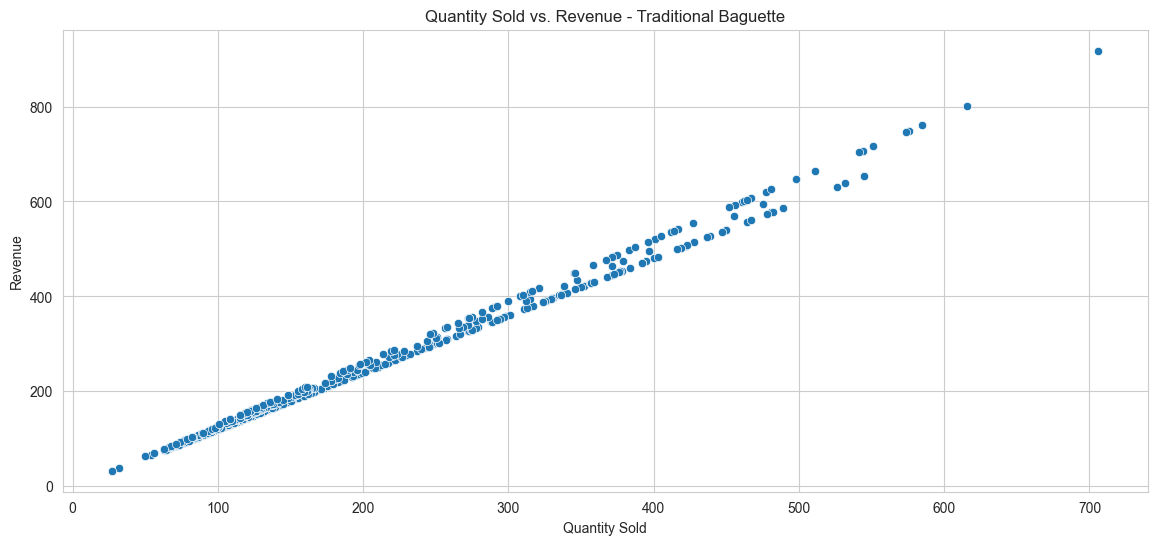

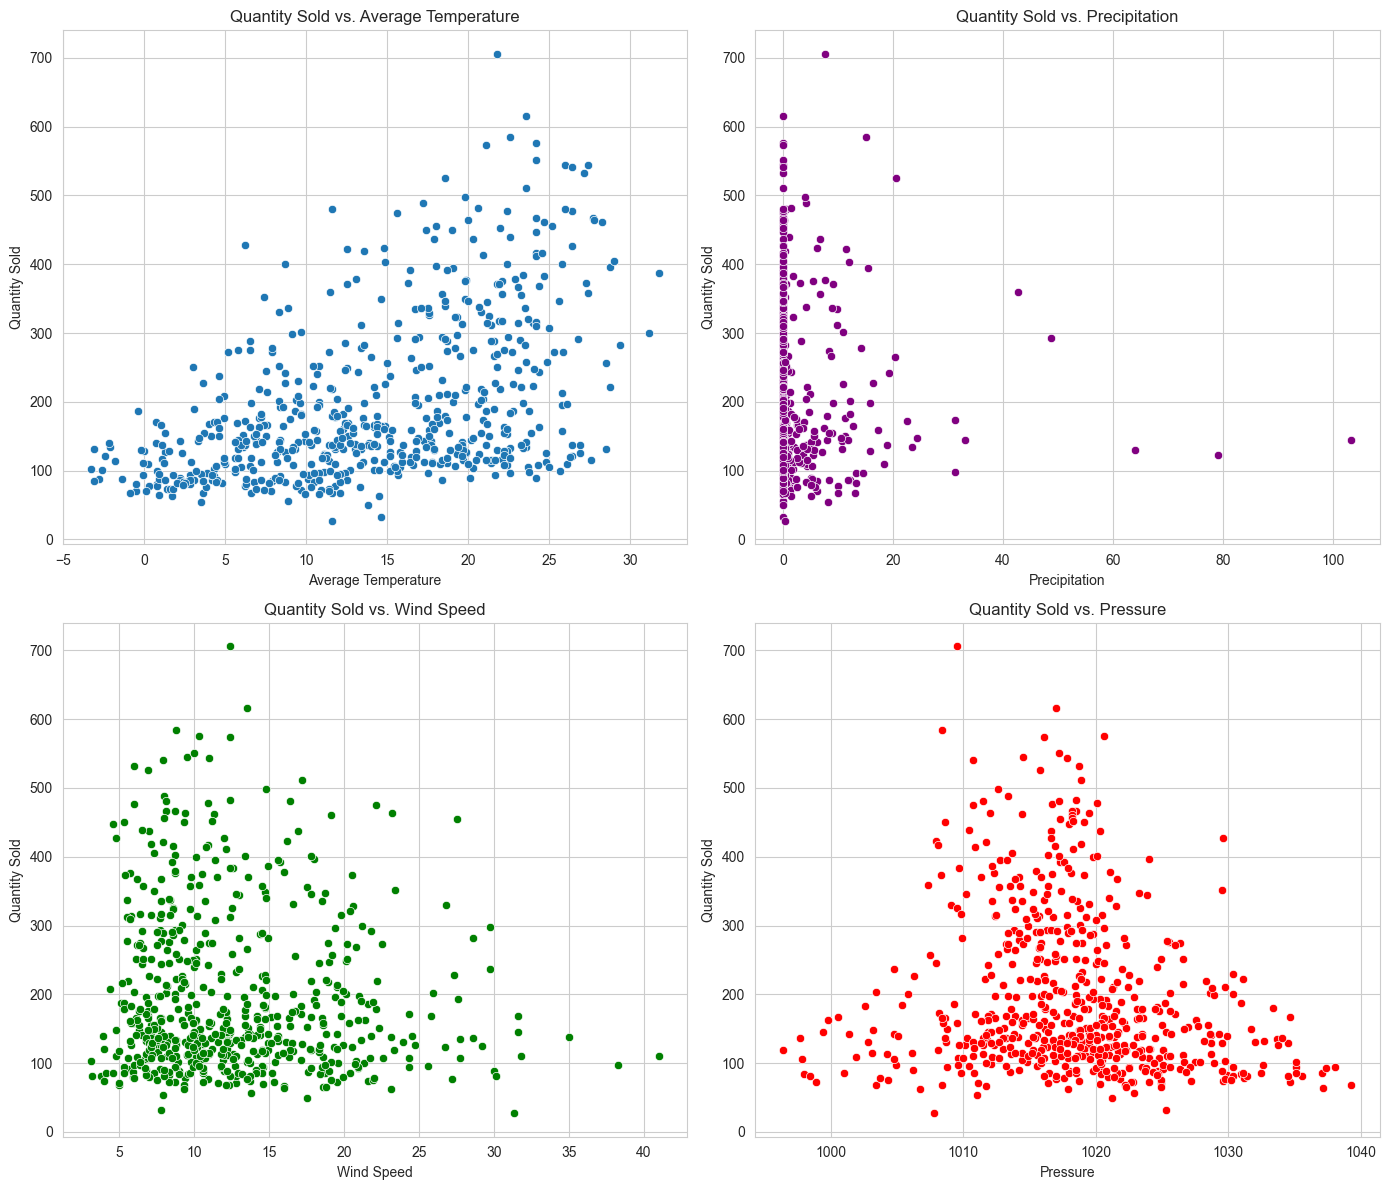

In [29]:
# Bivariate Analysis - Quantity Sold vs. Revenue
plt.figure(figsize=(14, 6))
sns.scatterplot(x='QuantitySold', y='Revenue', data=top_product_data)
plt.title('Quantity Sold vs. Revenue - Traditional Baguette')
plt.xlabel('Quantity Sold')
plt.ylabel('Revenue')
plt.show()

# Bivariate Analysis - Quantity Sold vs. Weather Variables
fig, axes = plt.subplots(2, 2, figsize=(14, 12))

sns.scatterplot(x='AvgTemp', y='QuantitySold', data=top_product_data, ax=axes[0, 0])
axes[0, 0].set_title('Quantity Sold vs. Average Temperature')
axes[0, 0].set_xlabel('Average Temperature')
axes[0, 0].set_ylabel('Quantity Sold')

sns.scatterplot(x='Precipitation', y='QuantitySold', data=top_product_data, ax=axes[0, 1], color='purple')
axes[0, 1].set_title('Quantity Sold vs. Precipitation')
axes[0, 1].set_xlabel('Precipitation')
axes[0, 1].set_ylabel('Quantity Sold')

sns.scatterplot(x='WindSpeed', y='QuantitySold', data=top_product_data, ax=axes[1, 0], color='green')
axes[1, 0].set_title('Quantity Sold vs. Wind Speed')
axes[1, 0].set_xlabel('Wind Speed')
axes[1, 0].set_ylabel('Quantity Sold')

sns.scatterplot(x='Pressure', y='QuantitySold', data=top_product_data, ax=axes[1, 1], color='red')
axes[1, 1].set_title('Quantity Sold vs. Pressure')
axes[1, 1].set_xlabel('Pressure')
axes[1, 1].set_ylabel('Quantity Sold')

plt.tight_layout()
plt.show()


**Quantity Sold vs. Revenue**

There's a clear positive correlation between quantity sold and revenue, which is expected as more sales lead to higher revenue.

**Quantity Sold vs. Weather Variables**

Temperature: Higher temperatures (up to around 25°C) are associated with higher sales of Traditional Baguettes.

Precipitation: Little effect.

Wind Speed: Lower wind speeds (5-15 km/h) are more conducive to higher sales.

Pressure: No clear correlation is observed between atmospheric pressure and sales quantities.


In [30]:
#top_product_data.to_csv('top_data.csv')

##### Time Series Analysis

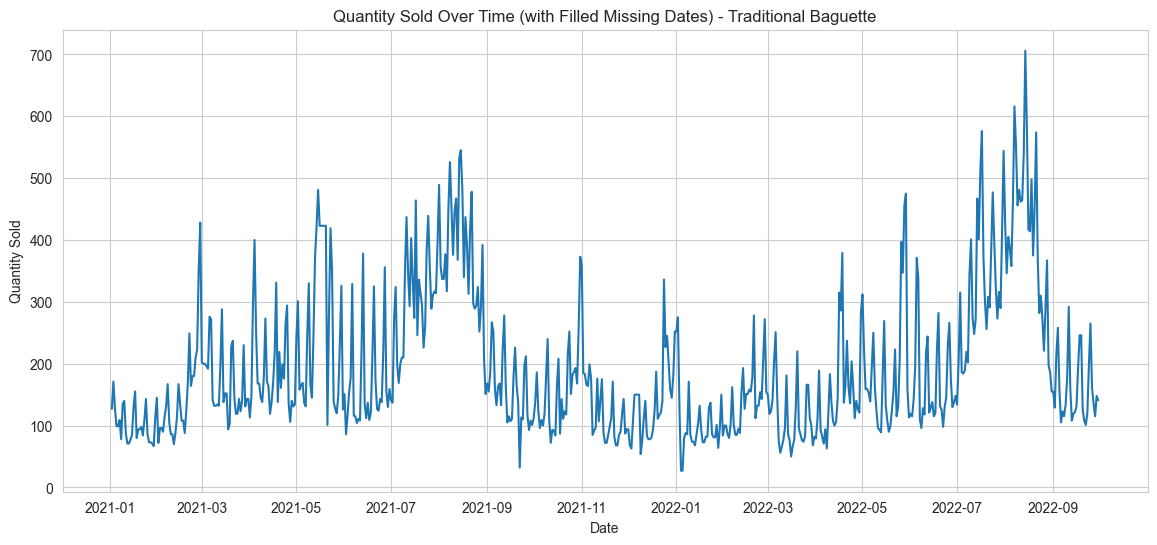

(DatetimeIndex([], dtype='datetime64[ns]', freq='D'), 0)

In [31]:
# Create a complete date range
date_range = pd.date_range(start=top_product_data.index.min(), end=top_product_data.index.max())
top_product_data = top_product_data.reindex(date_range).fillna(method='ffill')

# Plot the updated time series
plt.figure(figsize=(14, 6))
plt.plot(top_product_data['QuantitySold'])
plt.title('Quantity Sold Over Time (with Filled Missing Dates) - Traditional Baguette')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.show()

# Display missing dates if any
missing_dates = date_range.difference(top_product_data.index)
missing_dates, len(missing_dates)


##### Check Seasonality and Stationarity

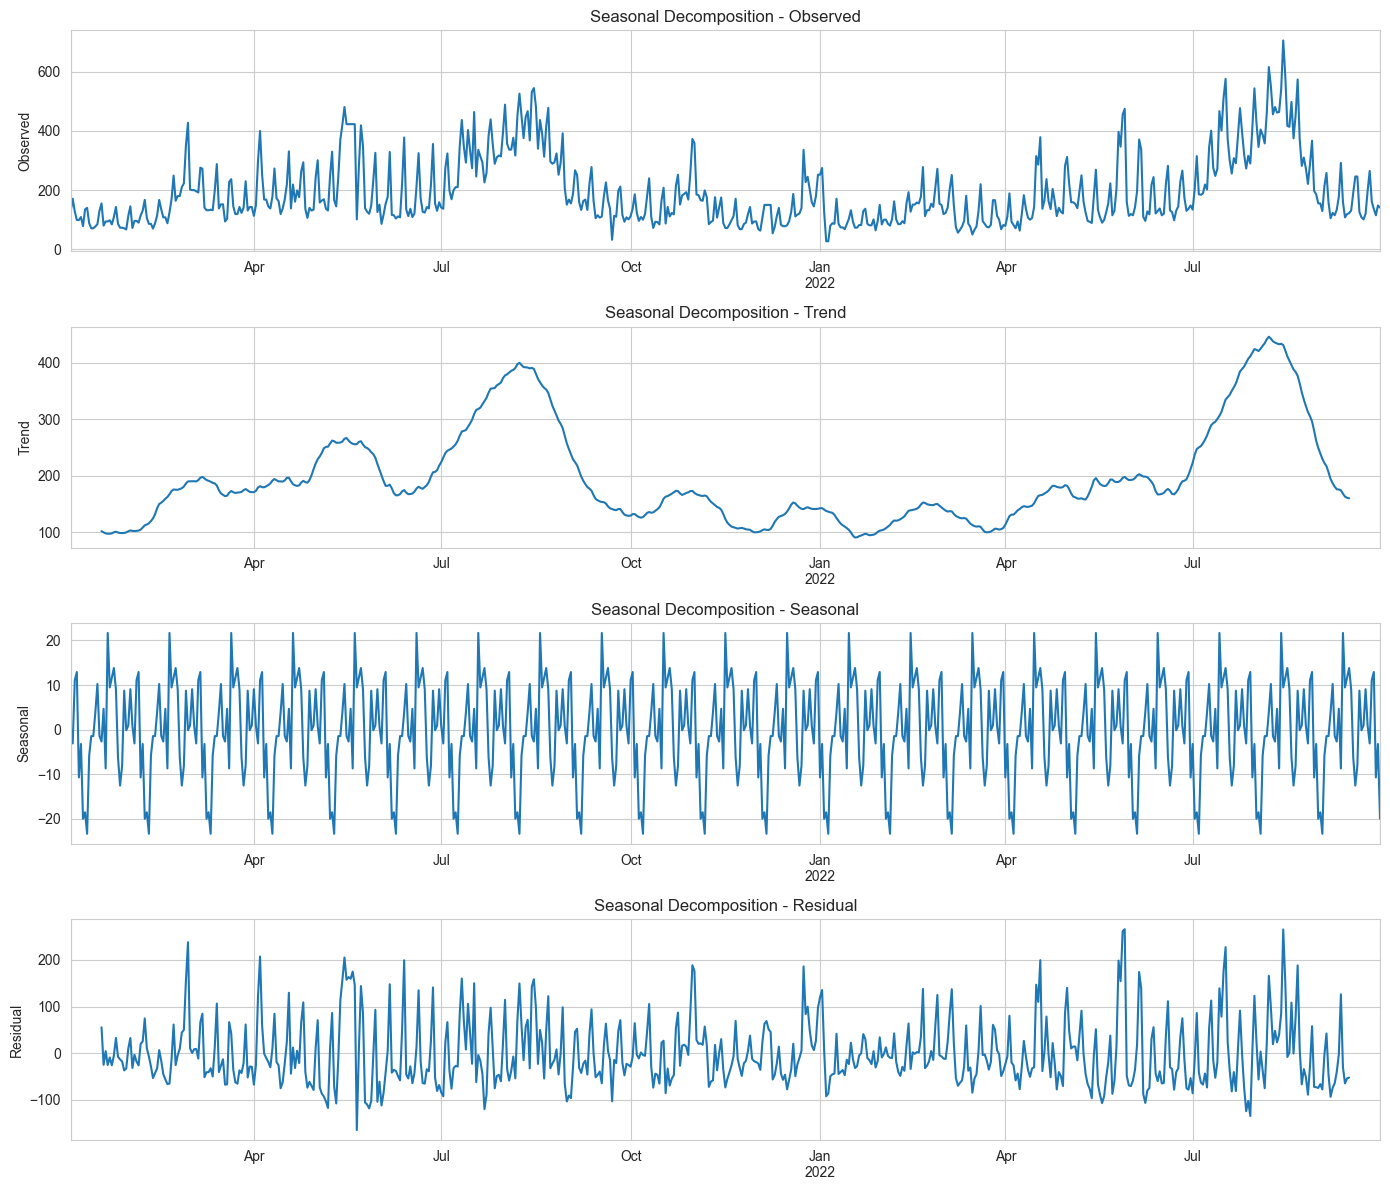

In [33]:
# Seasonal decomposition
decomposition = seasonal_decompose(top_product_data['QuantitySold'], model='additive', period=30)

# Plot the decomposed components
fig, (ax1, ax2, ax3, ax4) = plt.subplots(4, 1, figsize=(14, 12))

decomposition.observed.plot(ax=ax1)
ax1.set_ylabel('Observed')
ax1.set_title('Seasonal Decomposition - Observed')

decomposition.trend.plot(ax=ax2)
ax2.set_ylabel('Trend')
ax2.set_title('Seasonal Decomposition - Trend')

decomposition.seasonal.plot(ax=ax3)
ax3.set_ylabel('Seasonal')
ax3.set_title('Seasonal Decomposition - Seasonal')

decomposition.resid.plot(ax=ax4)
ax4.set_ylabel('Residual')
ax4.set_title('Seasonal Decomposition - Residual')

plt.tight_layout()
plt.show()


##### Augmented Dickey-Fuller (ADF) test 

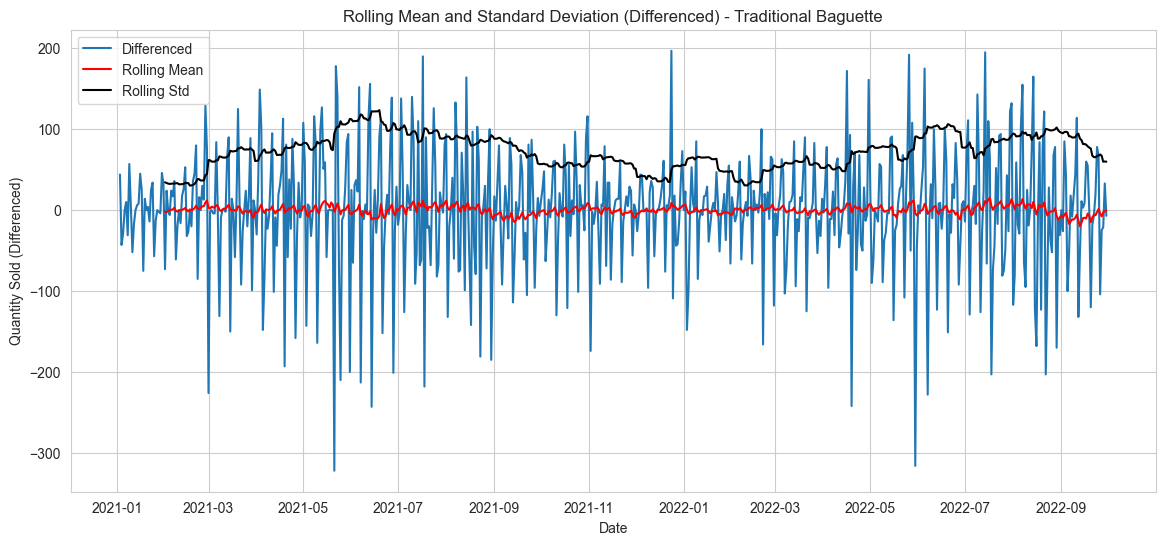

Test Statistic                -6.406398e+00
p-value                        1.938474e-08
Lags Used                      2.000000e+01
Number of Observations Used    6.150000e+02
Critical Value (1%)           -3.441028e+00
Critical Value (5%)           -2.866251e+00
Critical Value (10%)          -2.569279e+00
dtype: float64

In [34]:
# Apply differencing to achieve stationarity
top_product_data['QuantitySold_diff'] = top_product_data['QuantitySold'].diff()

# Drop NaN values resulting from differencing
top_product_data.dropna(subset=['QuantitySold_diff'], inplace=True)

# Recalculate rolling mean and variance after differencing
rolling_mean_diff = top_product_data['QuantitySold_diff'].rolling(window=30).mean()
rolling_std_diff = top_product_data['QuantitySold_diff'].rolling(window=30).std()

plt.figure(figsize=(14, 6))
plt.plot(top_product_data['QuantitySold_diff'], label='Differenced')
plt.plot(rolling_mean_diff, label='Rolling Mean', color='red')
plt.plot(rolling_std_diff, label='Rolling Std', color='black')
plt.title('Rolling Mean and Standard Deviation (Differenced) - Traditional Baguette')
plt.xlabel('Date')
plt.ylabel('Quantity Sold (Differenced)')
plt.legend()
plt.show()

# Perform the Augmented Dickey-Fuller test again after differencing
adf_test_diff = adfuller(top_product_data['QuantitySold_diff'])
adf_results_diff = pd.Series(adf_test_diff[:4], index=['Test Statistic', 'p-value', 'Lags Used', 'Number of Observations Used'])
for key, value in adf_test_diff[4].items():
    adf_results_diff[f'Critical Value ({key})'] = value

adf_results_diff


**Rolling Mean and Standard Deviation**

The rolling mean and standard deviation plots show more stability after differencing, indicating improved stationarity.

**Augmented Dickey-Fuller Test**

- Test statistic: -6.406
- P-value: 1.938e-08

The p-value is significantly less than 0.05, indicating that we can reject the null hypothesis of the presence of a unit root. This confirms that the differenced series is stationary.

**Seasonality**

Seasonality is confirmed through decomposition.

**Stationarity**

Stationarity is achieved through differencing, confirmed by the Augmented Dickey-Fuller test.


### Feature Engineering

In [35]:
top_product_data

,Product,QuantitySold,Revenue,Day,Month,Year,Weekday,Weekend,AvgTemp,MinTemp,MaxTemp,Precipitation,WindDir,WindSpeed,WindGust,Pressure,Season,QuantitySold_diff
2021-01-03,Traditional Baguette,171.0,205.2,3.0,1.0,2021.0,Sunday,True,0.7,-0.3,1.6,0.0,327.0,17.1,38.9,1012.1,Winter,44.0
2021-01-04,Traditional Baguette,128.0,153.6,4.0,1.0,2021.0,Monday,False,0.0,-1.0,1.1,0.0,329.0,10.6,30.0,1011.4,Winter,-43.0
2021-01-05,Traditional Baguette,99.0,118.8,5.0,1.0,2021.0,Tuesday,False,0.8,-0.9,2.1,0.0,338.0,6.2,30.0,1012.1,Winter,-29.0
2021-01-06,Traditional Baguette,99.0,118.8,5.0,1.0,2021.0,Tuesday,False,0.8,-0.9,2.1,0.0,338.0,6.2,30.0,1012.1,Winter,0.0
2021-01-07,Traditional Baguette,109.0,130.8,7.0,1.0,2021.0,Thursday,False,0.2,-1.6,2.5,0.0,343.0,6.2,24.0,1017.1,Winter,10.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2022-09-26,Traditional Baguette,161.0,209.3,26.0,9.0,2022.0,Monday,False,14.8,11.8,18.3,2.8,297.0,7.8,22.2,1011.3,Autumn,-104.0
2022-09-27,Traditional Baguette,136.0,176.8,27.0,9.0,2022.0,Tuesday,False,13.4,10.7,16.3,3.6,240.0,10.5,33.0,1008.6,Autumn,-25.0
2022-09-28,Traditional Baguette,115.0,149.5,28.0,9.0,2022.0,Wednesday,False,14.2,11.2,19.2,4.3,190.0,15.9,48.0,1003.1,Autumn,-21.0
2022-09-29,Traditional Baguette,148.0,192.4,29.0,9.0,2022.0,Thursday,False,12.2,9.3,15.7,24.4,321.0,6.9,18.5,1003.2,Autumn,33.0


##### Redundant Columns

In [36]:
# Reset the index and rename it to 'Date'
top_product_data.reset_index(inplace=True)
top_product_data.rename(columns={'index': 'Date'}, inplace=True)

# Drop unnecessary columns
columns_to_drop = ['Product', 'QuantitySold_diff', 'Day', 'Month', 'Year', 'WindGust', 'Pressure', 'Revenue']
top_product_data = top_product_data.drop(columns=columns_to_drop)

# Display the first few rows of the dataset after resetting index and dropping columns
top_product_data.head()

,Date,QuantitySold,Weekday,Weekend,AvgTemp,MinTemp,MaxTemp,Precipitation,WindDir,WindSpeed,Season
0,2021-01-03,171.0,Sunday,True,0.7,-0.3,1.6,0.0,327.0,17.1,Winter
1,2021-01-04,128.0,Monday,False,0.0,-1.0,1.1,0.0,329.0,10.6,Winter
2,2021-01-05,99.0,Tuesday,False,0.8,-0.9,2.1,0.0,338.0,6.2,Winter
3,2021-01-06,99.0,Tuesday,False,0.8,-0.9,2.1,0.0,338.0,6.2,Winter
4,2021-01-07,109.0,Thursday,False,0.2,-1.6,2.5,0.0,343.0,6.2,Winter


In [37]:
top_product_data['Date'] = pd.to_datetime(top_product_data['Date'])
top_product_data['Year'] = top_product_data['Date'].dt.year
top_product_data['Month'] = top_product_data['Date'].dt.month
top_product_data['Day'] = top_product_data['Date'].dt.day

In [38]:
top_product_data

,Date,QuantitySold,Weekday,Weekend,AvgTemp,MinTemp,MaxTemp,Precipitation,WindDir,WindSpeed,Season,Year,Month,Day
0,2021-01-03,171.0,Sunday,True,0.7,-0.3,1.6,0.0,327.0,17.1,Winter,2021,1,3
1,2021-01-04,128.0,Monday,False,0.0,-1.0,1.1,0.0,329.0,10.6,Winter,2021,1,4
2,2021-01-05,99.0,Tuesday,False,0.8,-0.9,2.1,0.0,338.0,6.2,Winter,2021,1,5
3,2021-01-06,99.0,Tuesday,False,0.8,-0.9,2.1,0.0,338.0,6.2,Winter,2021,1,6
4,2021-01-07,109.0,Thursday,False,0.2,-1.6,2.5,0.0,343.0,6.2,Winter,2021,1,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
631,2022-09-26,161.0,Monday,False,14.8,11.8,18.3,2.8,297.0,7.8,Autumn,2022,9,26
632,2022-09-27,136.0,Tuesday,False,13.4,10.7,16.3,3.6,240.0,10.5,Autumn,2022,9,27
633,2022-09-28,115.0,Wednesday,False,14.2,11.2,19.2,4.3,190.0,15.9,Autumn,2022,9,28
634,2022-09-29,148.0,Thursday,False,12.2,9.3,15.7,24.4,321.0,6.9,Autumn,2022,9,29


##### Feature Scaling

In [39]:
# Identify numerical features for scaling
numerical_features = ['QuantitySold','AvgTemp', 'MinTemp', 'MaxTemp', 'Precipitation', 'WindDir', 'WindSpeed']

# Initialize the scaler
scaler = StandardScaler()

# Scale the numerical features
top_product_data[numerical_features] = scaler.fit_transform(top_product_data[numerical_features])

# Display the first few rows of the scaled dataset
top_product_data.head()

,Date,QuantitySold,Weekday,Weekend,AvgTemp,MinTemp,MaxTemp,Precipitation,WindDir,WindSpeed,Season,Year,Month,Day
0,2021-01-03,-0.199476,Sunday,True,-1.666956,-1.381881,-1.899039,-0.312978,0.896964,0.737242,Winter,2021,1,3
1,2021-01-04,-0.567331,Monday,False,-1.756383,-1.481761,-1.954566,-0.312978,0.915466,-0.342145,Winter,2021,1,4
2,2021-01-05,-0.815419,Tuesday,False,-1.654181,-1.467492,-1.843512,-0.312978,0.998723,-1.072808,Winter,2021,1,5
3,2021-01-06,-0.815419,Tuesday,False,-1.654181,-1.467492,-1.843512,-0.312978,0.998723,-1.072808,Winter,2021,1,6
4,2021-01-07,-0.729871,Thursday,False,-1.730833,-1.567373,-1.799090,-0.312978,1.044977,-1.072808,Winter,2021,1,7


##### Encoding Categorical Variables

In [40]:
top_product_data.dtypes

Date             datetime64[ns]
QuantitySold            float64
Weekday                  object
Weekend                    bool
AvgTemp                 float64
MinTemp                 float64
MaxTemp                 float64
Precipitation           float64
WindDir                 float64
WindSpeed               float64
Season                   object
Year                      int32
Month                     int32
Day                       int32
dtype: object

In [41]:
# Create a mapping from weekday names to integers
weekday_mapping = {
    'Monday': 0,
    'Tuesday': 1,
    'Wednesday': 2,
    'Thursday': 3,
    'Friday': 4,
    'Saturday': 5,
    'Sunday': 6
}

season_mapping = {'Winter': 0, 'Spring': 1, 'Summer': 2, 'Autumn': 3}

top_product_data['Weekday'] = top_product_data['Weekday'].map(weekday_mapping)
top_product_data['Season'] = top_product_data['Season'].map(season_mapping)



In [42]:
# Convert Weekend to int for encoding
top_product_data['Weekend'] = top_product_data['Weekend'].astype(int)

# Apply one-hot encoding to Weekday and Weekend
df_encoded = pd.get_dummies(top_product_data, columns=['Weekday', 'Weekend', 'Season'], drop_first=True)

In [43]:
# Convert boolean columns to integers
boolean_columns = df_encoded.select_dtypes(include=['bool']).columns
df_encoded[boolean_columns] = df_encoded[boolean_columns].astype(int)

### Forecast

In [45]:
df = df_encoded

##### Linear Regression

In [46]:
from sklearn.ensemble import RandomForestRegressor

Linear Regression - Mean Squared Error: 0.6489753612062781, R-squared: 0.45661937170130074
Random Forest - Mean Squared Error: 0.4028843409067265, R-squared: 0.6626689403328205


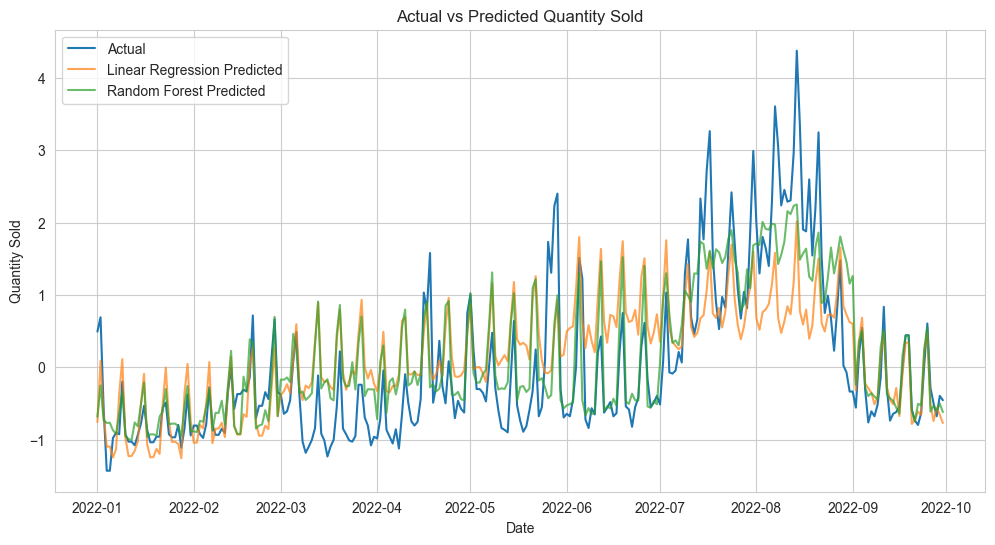

In [47]:
# Split the data
train_data = df[df['Date'] < '2022-01-01']
test_data = df[df['Date'] >= '2022-01-01']

# Keep the Date column in the test set for plotting
test_dates = test_data['Date']

# Drop the Date column for training and testing
train_data = train_data.drop(columns=['Date'])
test_data = test_data.drop(columns=['Date'])

# Split into features and target
X_train = train_data.drop(columns=['QuantitySold'])
y_train = train_data['QuantitySold']
X_test = test_data.drop(columns=['QuantitySold'])
y_test = test_data['QuantitySold']

# Initialize and train the Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)

# Predict on the test set
y_pred_lr = lr_model.predict(X_test)

# Evaluate the Linear Regression model
mse_lr = mean_squared_error(y_test, y_pred_lr)
r2_lr = r2_score(y_test, y_pred_lr)
print(f'Linear Regression - Mean Squared Error: {mse_lr}, R-squared: {r2_lr}')

# Initialize and train the Random Forest model
rf_model = RandomForestRegressor(random_state=42)
rf_model.fit(X_train, y_train)

# Predict on the test set
y_pred_rf = rf_model.predict(X_test)

# Evaluate the Random Forest model
mse_rf = mean_squared_error(y_test, y_pred_rf)
r2_rf = r2_score(y_test, y_pred_rf)
print(f'Random Forest - Mean Squared Error: {mse_rf}, R-squared: {r2_rf}')

# Plot the actual vs predicted values using the Date for the x-axis
plt.figure(figsize=(12, 6))

plt.plot(test_dates, y_test.values, label='Actual')
plt.plot(test_dates, y_pred_lr, label='Linear Regression Predicted', alpha=0.7)
plt.plot(test_dates, y_pred_rf, label='Random Forest Predicted', alpha=0.7)
plt.legend()
plt.title('Actual vs Predicted Quantity Sold')
plt.xlabel('Date')
plt.ylabel('Quantity Sold')
plt.show()

The results indicate that the Random Forest model significantly outperforms the Linear Regression model in terms of both Mean Squared Error (MSE) and R-squared (R²) values.

### Dashboard Visuals

In [48]:
import matplotlib.dates as mdates

In [49]:
data = pd.read_csv('top_data.csv')
data['Date'] = pd.to_datetime(data['Date'])

In [50]:
data

,Date,Product,QuantitySold,Revenue,Day,Month,Year,Weekday,Weekend,AvgTemp,MinTemp,MaxTemp,Precipitation,WindDir,WindSpeed,WindGust,Pressure,Season
0,2021-01-02,Traditional Baguette,127.0,152.4,2,1,2021,Saturday,True,1.3,0.5,2.7,0.8,336.0,24.7,44.0,1010.1,Winter
1,2021-01-03,Traditional Baguette,171.0,205.2,3,1,2021,Sunday,True,0.7,-0.3,1.6,0.0,327.0,17.1,38.9,1012.1,Winter
2,2021-01-04,Traditional Baguette,128.0,153.6,4,1,2021,Monday,False,0.0,-1.0,1.1,0.0,329.0,10.6,30.0,1011.4,Winter
3,2021-01-05,Traditional Baguette,99.0,118.8,5,1,2021,Tuesday,False,0.8,-0.9,2.1,0.0,338.0,6.2,30.0,1012.1,Winter
4,2021-01-07,Traditional Baguette,109.0,130.8,7,1,2021,Thursday,False,0.2,-1.6,2.5,0.0,343.0,6.2,24.0,1017.1,Winter
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
595,2022-09-26,Traditional Baguette,161.0,209.3,26,9,2022,Monday,False,14.8,11.8,18.3,2.8,297.0,7.8,22.2,1011.3,Autumn
596,2022-09-27,Traditional Baguette,136.0,176.8,27,9,2022,Tuesday,False,13.4,10.7,16.3,3.6,240.0,10.5,33.0,1008.6,Autumn
597,2022-09-28,Traditional Baguette,115.0,149.5,28,9,2022,Wednesday,False,14.2,11.2,19.2,4.3,190.0,15.9,48.0,1003.1,Autumn
598,2022-09-29,Traditional Baguette,148.0,192.4,29,9,2022,Thursday,False,12.2,9.3,15.7,24.4,321.0,6.9,18.5,1003.2,Autumn


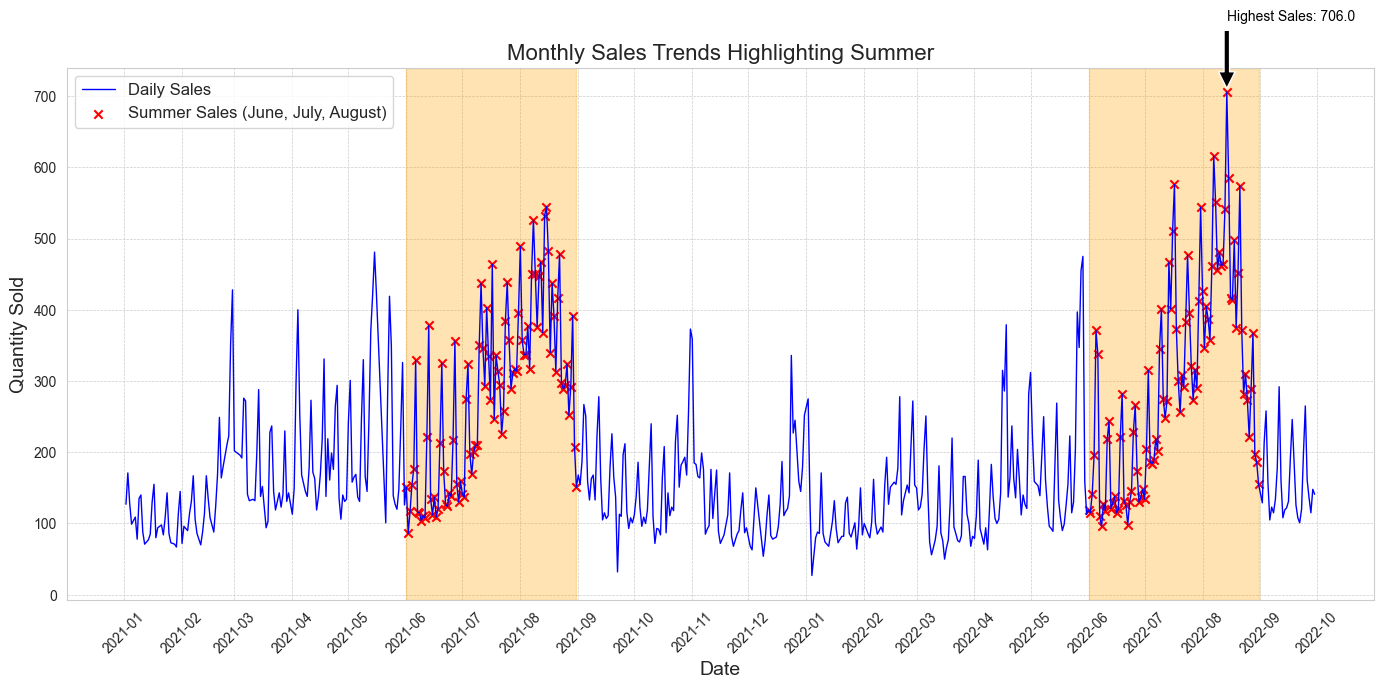

In [51]:
# Create the improved Monthly Sales Trends Highlighting Summer chart with summer months clearly labeled
plt.figure(figsize=(14, 7))

# Plot daily sales with a thinner line
plt.plot(data['Date'], data['QuantitySold'], linestyle='-', linewidth=1, color='blue', label='Daily Sales')

# Highlight summer months with a shaded area
for year in data['Year'].unique():
    plt.axvspan(pd.Timestamp(year=year, month=6, day=1), pd.Timestamp(year=year, month=8, day=31), color='orange', alpha=0.3)

# Scatter plot for summer sales with markers
summer_data = data[data['Season'] == 'Summer']
plt.scatter(summer_data['Date'], summer_data['QuantitySold'], color='red', label='Summer Sales (June, July, August)', marker='x')

# Annotate highest sales point
max_sales_date = data.loc[data['QuantitySold'].idxmax(), 'Date']
max_sales_value = data['QuantitySold'].max()
plt.annotate(f'Highest Sales: {max_sales_value}', xy=(max_sales_date, max_sales_value), xytext=(max_sales_date, max_sales_value+100),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10, color='black')

# Set title and labels
plt.title('Monthly Sales Trends Highlighting Summer', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Quantity Sold', fontsize=14)

# Format the x-axis dates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add grid, legend, and style adjustments
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper left', fontsize=12)
plt.tight_layout()

# Show plot
plt.show()


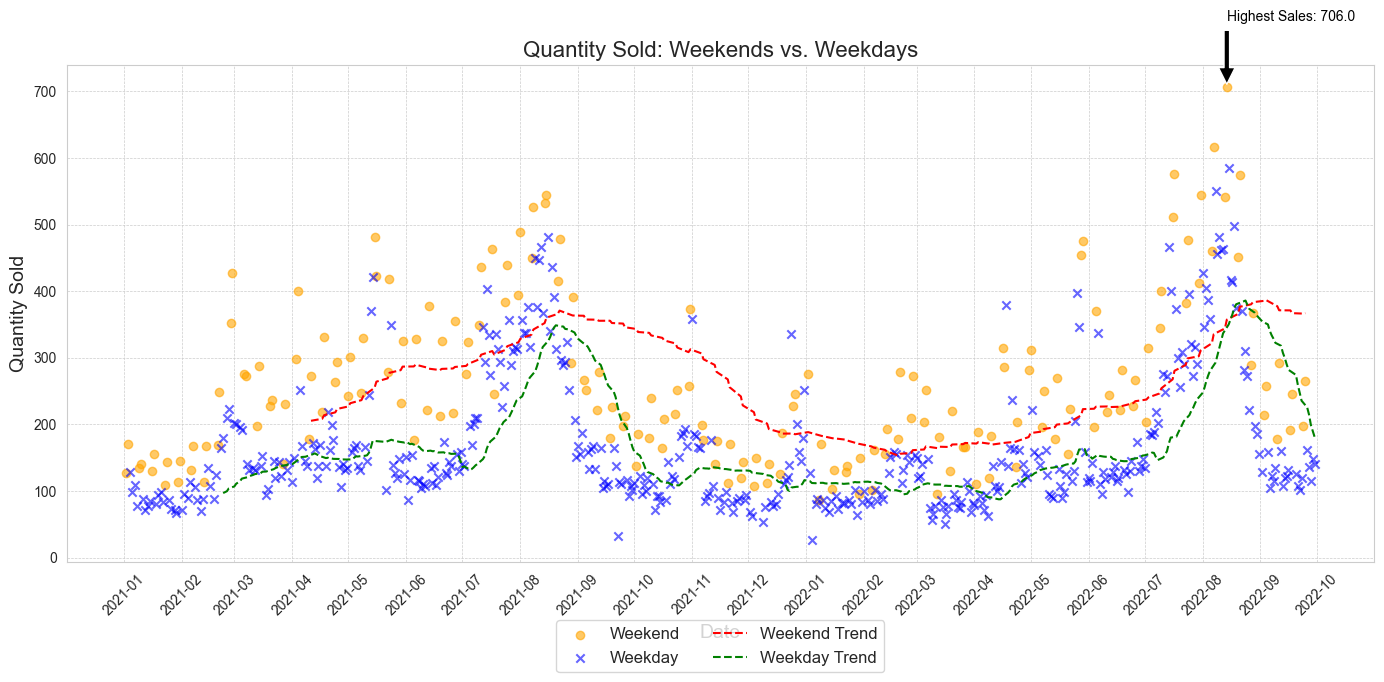

In [52]:
# Create a new column to label weekends and weekdays
data['DayType'] = data['Weekend'].apply(lambda x: 'Weekend' if x else 'Weekday')
# Re-check the Date column and ensure it is in datetime format
data['Date'] = pd.to_datetime(data['Date'], format='%Y-%m-%d', errors='coerce')

# Drop any rows with invalid dates
data = data.dropna(subset=['Date'])

# Create the improved scatter plot again with corrected dates
plt.figure(figsize=(14, 7))

# Plot weekends
weekend_data = data[data['DayType'] == 'Weekend']
plt.scatter(weekend_data['Date'], weekend_data['QuantitySold'], color='orange', marker='o', label='Weekend', alpha=0.6)

# Plot weekdays
weekday_data = data[data['DayType'] == 'Weekday']
plt.scatter(weekday_data['Date'], weekday_data['QuantitySold'], color='blue', marker='x', label='Weekday', alpha=0.6)

# Add trend lines
plt.plot(weekend_data['Date'], weekend_data['QuantitySold'].rolling(window=30).mean(), color='red', linestyle='--', label='Weekend Trend')
plt.plot(weekday_data['Date'], weekday_data['QuantitySold'].rolling(window=30).mean(), color='green', linestyle='--', label='Weekday Trend')

# Annotate highest sales point
max_sales_date = data.loc[data['QuantitySold'].idxmax(), 'Date']
max_sales_value = data['QuantitySold'].max()
plt.annotate(f'Highest Sales: {max_sales_value}', xy=(max_sales_date, max_sales_value), xytext=(max_sales_date, max_sales_value+100),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10, color='black')

# Set title and labels
plt.title('Quantity Sold: Weekends vs. Weekdays', fontsize=16)
plt.xlabel('Date', fontsize=14)
plt.ylabel('Quantity Sold', fontsize=14)

# Format the x-axis dates
plt.gca().xaxis.set_major_locator(mdates.MonthLocator())
plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Rotate date labels for better readability
plt.xticks(rotation=45)

# Add grid, legend, and style adjustments
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.1), ncol=2, fontsize=12)
plt.tight_layout()

# Show plot
plt.show()




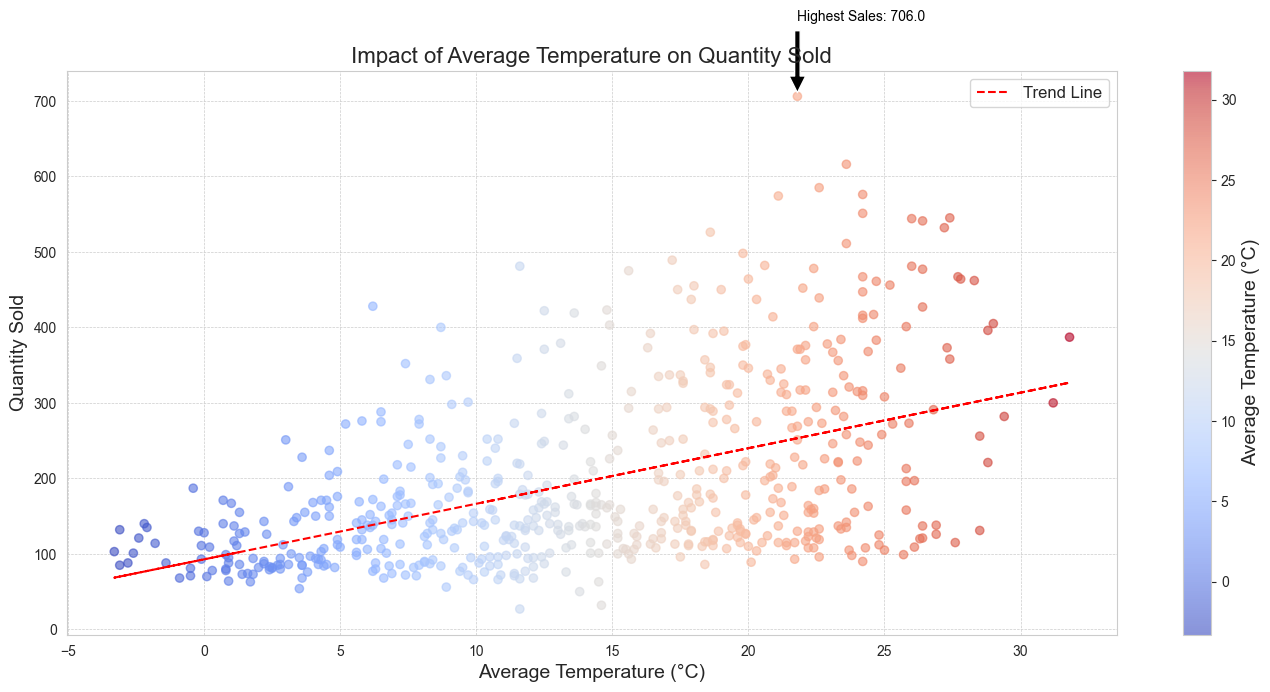

In [53]:
# Create a scatter plot to show the impact of AvgTemp on QuantitySold

# Create the improved scatter plot
plt.figure(figsize=(14, 7))

# Plot data points with a color gradient based on temperature
sc = plt.scatter(data['AvgTemp'], data['QuantitySold'], c=data['AvgTemp'], cmap='coolwarm', alpha=0.6)

# Add a color bar
cbar = plt.colorbar(sc)
cbar.set_label('Average Temperature (°C)', fontsize=14)

# Add trend line
z = np.polyfit(data['AvgTemp'], data['QuantitySold'], 1)
p = np.poly1d(z)
plt.plot(data['AvgTemp'], p(data['AvgTemp']), "r--", label='Trend Line')

# Annotate highest sales point
max_sales_temp = data.loc[data['QuantitySold'].idxmax(), 'AvgTemp']
max_sales_value = data['QuantitySold'].max()
plt.annotate(f'Highest Sales: {max_sales_value}', xy=(max_sales_temp, max_sales_value), xytext=(max_sales_temp, max_sales_value+100),
             arrowprops=dict(facecolor='black', shrink=0.05), fontsize=10, color='black')

# Set title and labels
plt.title('Impact of Average Temperature on Quantity Sold', fontsize=16)
plt.xlabel('Average Temperature (°C)', fontsize=14)
plt.ylabel('Quantity Sold', fontsize=14)

# Add grid and style adjustments
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.legend(loc='upper right', fontsize=12)
plt.tight_layout()

# Show plot
plt.show()
